In [8]:
import pandas as pd
from Bio import SeqIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from IPython.display import Image

def parseFasta(data):
    d = {fasta.id : str(fasta.seq) for fasta in SeqIO.parse(data, "fasta")}
    pd.DataFrame([d])

    s = pd.Series(d, name='Sequence')
    s.index.name = 'ID'
    s.reset_index()
    return pd.DataFrame(s)

def kmerXTable(s, a, b):
    tfid_vector = TfidfVectorizer(analyzer='char', ngram_range=(a,b))
    s_hat = tfid_vector.fit_transform(s.Sequence)
    kmerNames = tfid_vector.get_feature_names()
    kmers = s_hat.toarray()
    return pd.DataFrame(kmers,columns=kmerNames, index = s.index)
    
def kmeans(fasta, cNum, klength_min = 6, klength_max = 6, rNum = 50):
    inputData = parseFasta(fasta)
#     temp = virus01.append(inputData)
#     temp = temp.drop_duplicates(keep="last")
        
    inputData["Sequence"] = inputData["Sequence"].apply(lambda x: x.replace("-", ""))
    kmerXTableInput = kmerXTable(inputData, klength_min, klength_max)
        
        
    km = KMeans(random_state = rNum, n_clusters = cNum)
    km.fit(kmerXTableInput) 
    y_hat = km.predict(kmerXTableInput)
        
    return y_hat, kmerXTableInput
        
def kmeans_semiSupervised(fasta, y_hat, klength_min = 6, klength_max = 6, rNum = 50):
    inputData = parseFasta(fasta)
    inputData["Sequence"] = inputData["Sequence"].apply(lambda x: x.replace("-", ""))
    kmerXTableInput = kmerXTable(inputData, klength_min, klength_max)
    
    PCAembedding = PCA(n_components=10)
    NkmerXTableInput = preprocessing.normalize(kmerXTableInput)
    PCAembedding_low = PCAembedding.fit_transform(NkmerXTableInput)
    
    ms = MeanShift()
    ms.fit(PCAembedding_low)
    cluster_centers = ms.cluster_centers_

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        kmms = KMeans(init = cluster_centers, n_clusters = len(cluster_centers))
        kmms_labels = kmms.fit_predict(PCAembedding_low)

    # convert all clusters into two clusters
    kmerXTableInput["pLabels"] = kmms_labels
    kmerXTableInput["aLabels"] = y_hat
    newLabels_clusters_1 = kmerXTableInput[kmerXTableInput["aLabels"] == 1]["pLabels"].tolist()
    newLabels_clusters_0 = kmerXTableInput[kmerXTableInput["aLabels"] == 0]["pLabels"].tolist()
    newLabels = []

    for label in kmms_labels:
        if (newLabels_clusters_1.count(label) > newLabels_clusters_0.count(label)):
            newLabels.append(1)
        else:
            newLabels.append(0)
            
    return newLabels, kmerXTableInput.drop(columns=["pLabels", "aLabels"])
    
def PCA2d(kTable, y_hat, filename):
    embedding = PCA(n_components= 2)
    nkTable = preprocessing.normalize(kTable)
    embedding.fit(nkTable)
    show = pd.DataFrame(embedding.transform(nkTable))
    # show kmeans clustering
    show["labels"] = y_hat
    ax = show[show["labels"]==1].plot.scatter(x=0, y=1, style="o", color="red", s=2)
    show[show["labels"]==0].plot.scatter(x=0, y=1, style="o", color="blue", s=2, ax=ax)
    show[(show["labels"]!= 0) & (show["labels"]!= 1) ].plot.scatter(x=0, y=1, style="o", color="gray", s=2, ax=ax)
    red = mpatches.Patch(color='red', label='Label 1')
    blue = mpatches.Patch(color='blue', label='Label 0')
    grey = mpatches.Patch(color='grey', label='Label -1')
    plt.legend(handles=[red, blue, grey])
    plt.title('PCA Visualization')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.savefig('nonNotebookFiles/' + filename + '.png', bbox_inches='tight')
    plt.close()
    show.to_csv('nonNotebookFiles/' + filename + "_PCA.csv")
            
def tSNE2d(kTable, y_hat, filename):
    tSNEembedding = TSNE(n_components= 2, random_state = 0)
    tSNEembedding_low = tSNEembedding.fit_transform(kTable)
    show = pd.DataFrame(tSNEembedding_low)
    # show kmeans clustering
    show["labels"] = y_hat
    ax = show[show["labels"]==1].plot.scatter(x=0, y=1, style="o", color="red", s=2)
    show[show["labels"]==0].plot.scatter(x=0, y=1, style="o", color="blue", s=2, ax=ax)
    show[(show["labels"]!= 0) & (show["labels"]!= 1) ].plot.scatter(x=0, y=1, style="o", color="gray", s=2, ax=ax)
    red = mpatches.Patch(color='red', label='Label 1')
    blue = mpatches.Patch(color='blue', label='Label 0')
    grey = mpatches.Patch(color='grey', label='Label -1')
    plt.legend(handles=[red, blue, grey])
    plt.title('tSNE Visualization\n')
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.savefig('nonNotebookFiles/' + filename + '.png', bbox_inches='tight')
    plt.close()
    show.to_csv('nonNotebookFiles/' + filename + "_tSNE.csv")

In [7]:
flu_data = "../data/combined_Bat_Cat_flu.fa"
flu10_labels = pd.read_csv("../data/labels_ten_percent.csv").Labels.tolist()
flu50_labels = pd.read_csv("../data/labels_fifty_percent.csv").Labels.tolist()
flu_actual_labels = pd.read_csv("../data/actual_labels.csv").Labels.tolist()
flu_only0_labels = pd.read_csv("../data/labels_ten_percent_only0s.csv").Labels.tolist()

In [6]:
y_hat_only0, kmer_only0 = kmeans_semiSupervised(flu_data, flu_only0_labels, 6, 7, 50)
PCA2d(kmer_only0, y_hat_only0, "test10_0")

In [7]:
y_hat0, kmer0 = kmeans(flu_data, 2, 6, 7, 50)
y_hat10, kmer10 = kmeans_semiSupervised(flu_data, flu10_labels,  2, 3, 50)
y_hat50, kmer50 = kmeans_semiSupervised(flu_data, flu50_labels, 2, 3, 50)

In [9]:
donly0 = {'real10': flu_actual_labels, 'pred10': y_hat0}
dfonly20 = pd.DataFrame(data=donly0)
print(len(dfonly20[(dfonly20['real10'] != -1) & (dfonly20['real10'] == dfonly20['pred10'])])/len(dfonly20[dfonly20['real10'] != -1])*100)

donly0 = {'real10': flu_actual_labels, 'pred10': y_hat50}
dfonly20 = pd.DataFrame(data=donly0)
print(len(dfonly20[(dfonly20['real10'] != -1) & (dfonly20['real10'] == dfonly20['pred10'])])/len(dfonly20[dfonly20['real10'] != -1])*100)

donly0 = {'real10': flu_actual_labels, 'pred10': y_hat10}
dfonly20 = pd.DataFrame(data=donly0)
print(len(dfonly20[(dfonly20['real10'] != -1) & (dfonly20['real10'] == dfonly20['pred10'])])/len(dfonly20[dfonly20['real10'] != -1])*100)

donly0 = {'real10': flu_actual_labels, 'pred10': y_hat_only0}
dfonly20 = pd.DataFrame(data=donly0)
print(len(dfonly20[(dfonly20['real10'] != -1) & (dfonly20['real10'] == dfonly20['pred10'])])/len(dfonly20[dfonly20['real10'] != -1])*100)

donly0 = {'real10': flu50_labels, 'pred10': y_hat50}
dfonly20 = pd.DataFrame(data=donly0)
print(len(dfonly20[(dfonly20['real10'] != -1) & (dfonly20['real10'] == dfonly20['pred10'])])/len(dfonly20[dfonly20['real10'] != -1])*100)

donly0 = {'real10': flu10_labels, 'pred10': y_hat10}
dfonly20 = pd.DataFrame(data=donly0)
print(len(dfonly20[(dfonly20['real10'] != -1) & (dfonly20['real10'] == dfonly20['pred10'])])/len(dfonly20[dfonly20['real10'] != -1])*100)

donly0 = {'real10': flu_only0_labels, 'pred10': y_hat_only0}
dfonly20 = pd.DataFrame(data=donly0)
print(len(dfonly20[(dfonly20['real10'] != -1) & (dfonly20['real10'] == dfonly20['pred10'])])/len(dfonly20[dfonly20['real10'] != -1])*100)

55.0561797752809
64.04494382022472
66.29213483146067
35.95505617977528
64.04494382022472
70.58823529411765
100.0


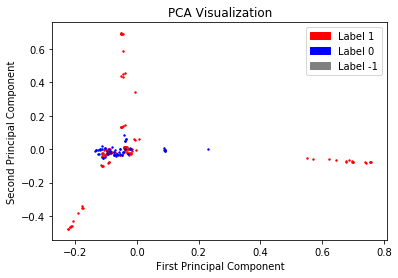

In [10]:
PCA2d(kmer_only0, flu_actual_labels, "flu")
Image("nonNotebookFiles/flu.png")

In [10]:
PCA2d(kmer_only0, flu_only0_labels, "realonly0")
PCA2d(kmer_only0, y_hat_only0, "testonly0")

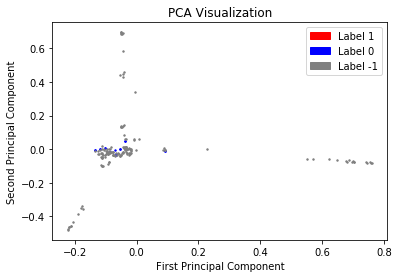

In [11]:
Image("nonNotebookFiles/realonly0.png")

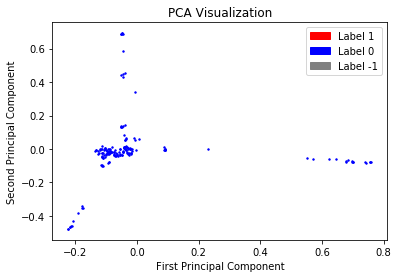

In [12]:
Image("nonNotebookFiles/testonly0.png")

In [13]:
donly0 = {'real10': flu_only0_labels, 'pred10': y_hat_only0}
dfonly20 = pd.DataFrame(data=donly0)
len(dfonly20[(dfonly20['real10'] != -1) & (dfonly20['real10'] == dfonly20['pred10'])])/len(dfonly20[dfonly20['real10'] != -1])*100

100.0

In [5]:
PCA2d(kmer0, y_hat0, "test0")
PCA2d(kmer10, y_hat10, "test10")
PCA2d(kmer50, y_hat50, "test50")

PCA2d(kmer0, flu10_labels, "real10")
PCA2d(kmer0, flu50_labels, "real50")

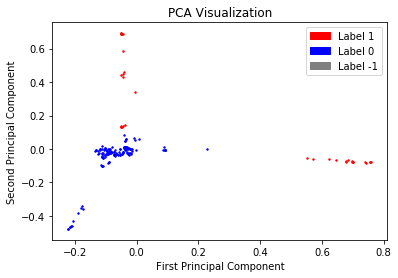

In [6]:
Image("nonNotebookFiles/test0.png")

In [7]:
d10 = {'real10': flu10_labels, 'pred10': y_hat10}
df10 = pd.DataFrame(data=d10)
len(df10[(df10['real10'] != -1) & (df10['real10'] == df10['pred10'])])/len(df10[df10['real10'] != -1])*100

70.58823529411765

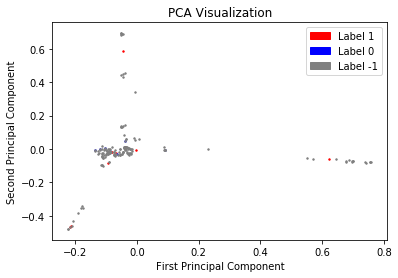

In [8]:
Image("nonNotebookFiles/real10.png")

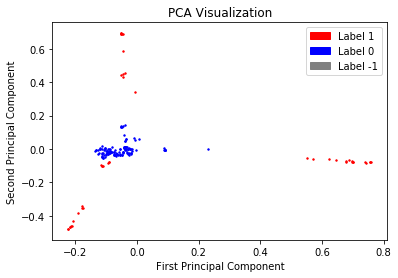

In [9]:
Image("nonNotebookFiles/test10.png")

In [10]:
d50 = {'real50': flu50_labels, 'pred50': y_hat50}
df50 = pd.DataFrame(data=d50)
len(df50[(df50['real50'] != -1) & (df50['real50'] == df50['pred50'])])/len(df50[df50['real50'] != -1]) * 100

71.91011235955057

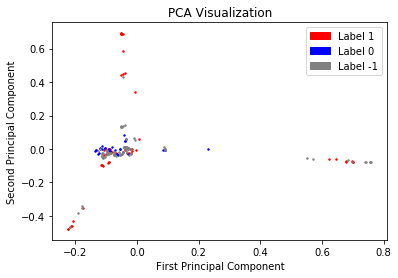

In [11]:
Image("nonNotebookFiles/real50.png")

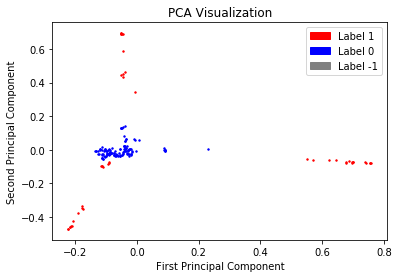

In [12]:
Image("nonNotebookFiles/test50.png")